In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [4]:
my_data_dir = r"C:\Users\avati\Downloads\cell_images\cell_images"

In [5]:
os.listdir(my_data_dir) 

['test', 'train']

In [6]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [7]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [8]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [9]:
os.listdir(train_path+'\\parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [10]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [11]:
para_img= imread(para_cell)

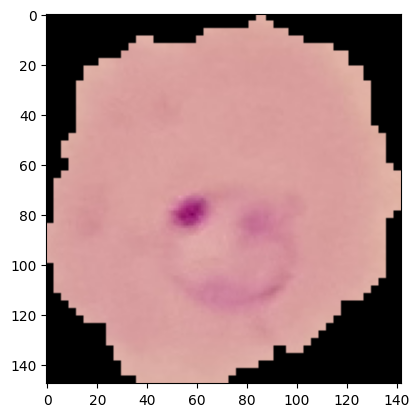

In [12]:
plt.imshow(para_img)

In [13]:
para_img.shape

(148, 142, 3)

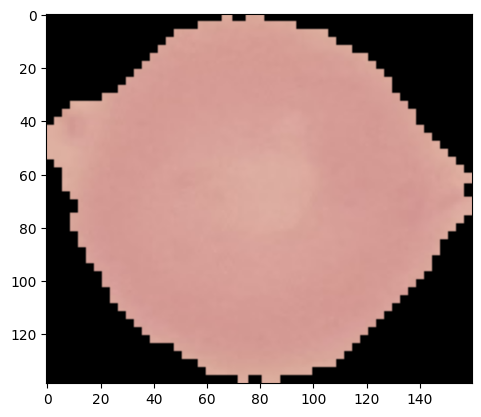

In [14]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [15]:
len(os.listdir(train_path+'\\parasitized'))

12480

In [16]:
len(os.listdir(train_path+'\\uninfected'))

12480

In [17]:
unifected_cell.shape

(139, 160, 3)

In [18]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path+'\\uninfected'):
    
    img = imread(test_path+'\\uninfected'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

C:\Users\avati\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


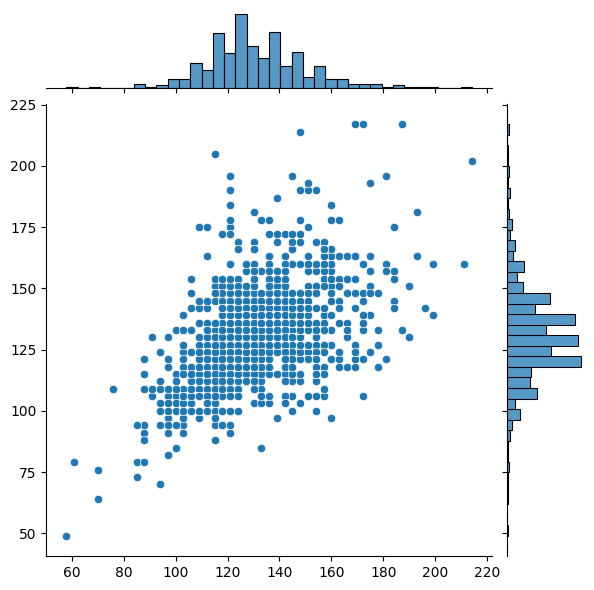

In [19]:
sns.jointplot(dim1,dim2)

In [20]:
np.mean(dim1)

130.92538461538462

In [21]:
np.mean(dim2)

130.75

In [22]:
image_shape = (130,130,3)

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

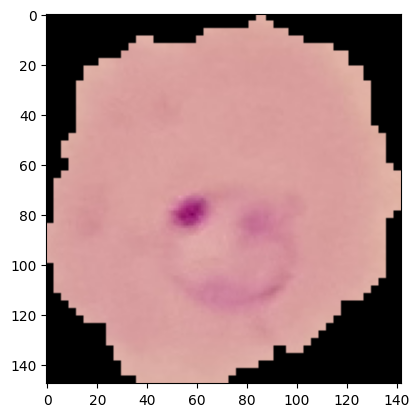

In [25]:
plt.imshow(para_img)

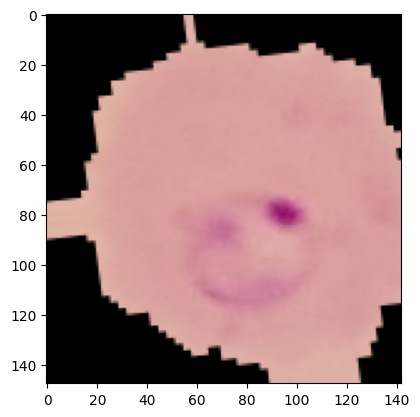

In [26]:
plt.imshow(image_gen.random_transform(para_img))

In [27]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [28]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [29]:
#creating the model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [31]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [35]:
batch_size = 16

In [36]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [37]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [38]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [39]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

In [40]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [42]:
model.metrics_names

['loss', 'accuracy']

In [43]:
model.evaluate_generator(test_image_gen)

[0.6920678019523621, 0.5276923179626465]

In [44]:
from tensorflow.keras.preprocessing import image

In [45]:
pred_probabilities = model.predict_generator(test_image_gen)

In [46]:
pred_probabilities

array([[0.5196663 ],
       [0.4909688 ],
       [0.5038253 ],
       ...,
       [0.5157656 ],
       [0.50759286],
       [0.49809745]], dtype=float32)

In [47]:
predictions = pred_probabilities > 0.5

In [48]:
predictions

array([[ True],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

In [49]:
from sklearn.metrics import classification_report,confusion_matrix

In [50]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.62      0.18      0.28      1300
           1       0.52      0.89      0.66      1300

    accuracy                           0.54      2600
   macro avg       0.57      0.54      0.47      2600
weighted avg       0.57      0.54      0.47      2600



In [51]:
confusion_matrix(test_image_gen.classes,predictions)

array([[ 238, 1062],
       [ 146, 1154]], dtype=int64)

In [52]:
para_cell

'C:\\Users\\avati\\Downloads\\cell_images\\cell_images\\train\\\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [53]:
my_image = image.load_img(para_cell,target_size=image_shape)

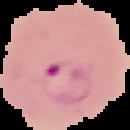

In [54]:
my_image

In [55]:
my_image = image.img_to_array(my_image)

In [56]:
my_image

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [57]:
my_image.shape

(130, 130, 3)

In [58]:
my_image = np.expand_dims(my_image, axis=0)

In [59]:
my_image.shape

(1, 130, 130, 3)

In [60]:
model.predict(my_image)

1/1 [==============================] - 0s 111ms/step


array([[0.9997402]], dtype=float32)

In [61]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [62]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}